<font color = blue><font size = 6> H(ALF)DLSTM </font></font><br>
결론적으로 LSTM은 seasonal에 주고 trend와 seasonal의 비율을 적당히 맞추는게 중요함<br>
&rightarrow; 이번에는 scaling 없이

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [5]:
class Seasonal_Encoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [6]:
class Seasonal_Decoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [7]:
tup= (1,2)
len(tup)

2

In [8]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [9]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [10]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.season_encoder = Seasonal_Encoder(configs)
        self.season_decoder = Seasonal_Decoder(configs)
        self.Linear_Sum = nn.Linear(2,1)
        self.Linear_Trend = nn.Linear(1440,1)
        
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.to(self.device) 

        _,final_season_hidden = self.season_encoder(seasonal_init)
        season_output,_ = self.season_decoder(x = seasonal_init[:,-1,:].view(-1,1,1),encoder_hidden = final_season_hidden)
        trend_output = self.Linear_Trend(trend_init)
        SUM_OUTPUT = self.Linear_Sum(torch.cat([season_output,trend_output],dim=2))
        output = SUM_OUTPUT
        
        return output,season_output,trend_output

In [11]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [12]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_536403/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [14]:
target

tensor([[[22.0614]],

        [[22.0653]],

        [[22.0655]],

        ...,

        [[22.4421]],

        [[22.4284]],

        [[22.4296]]], device='cuda:0')

In [15]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [16]:
torch.manual_seed(42)

In [17]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [18]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#        print(out)
        loss = criterion(out,tg)
    
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 9.392559459270931 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 6.531564368344217 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 4.271812923579362 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 3.9034710468197438 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 3.2164289372154835 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 3.199444911541412 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 2.9842912081332216 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 2.614703118787161 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 2.206018571231285 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 1.9662287269959944 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 1.8714146394512687 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 1.4469487762724715 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 1.3752374933332705 %
Adjus

In [19]:
print(ss_list[26])
print(tr_list[0])

tensor([[[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0532]],

        [[0.0534]],

        [[0.0535]],

        [[0.0532]],

        [[0.0534]],

        [[0.0535]],

        [[0.0535]],

        [[0.0535]],

        [[0.0534]],

        [[0.0533]],

        [[0.0533]],

        [[0.0532]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0533]],

        [[0.0534]],

        [[0.0534]],

        [[0.0533]],

        [[0.0533]]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[[-19.2914]],

        [[-19.2909]],

        [[-19.2908]],

        [[-19.2913]],

        [[-19.2912]],

        [[-19.2915]],

        [[-19.2910]],

        [[-19.2906]],

        [[-19.2902]],

        [[-19.2898]],

        [[-19.2889]],

        [[-19.2891]],

        [[

In [20]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.11733683312922949 %
SMAPE 0.016806530401041186 %
SMAPE 0.015932656896268327 %
SMAPE 0.030150679823918836 %
SMAPE 0.010907899097396978 %
SMAPE 0.0050382236101427225 %
SMAPE 0.012102744066851301 %
SMAPE 0.008988426203359268 %
SMAPE 0.014729510388860945 %
SMAPE 0.015266756183109463 %
SMAPE 0.029818097067959574 %
SMAPE 0.021554357786953915 %
SMAPE 0.021551176130742533 %
SMAPE 0.013729784790371015 %
SMAPE 0.014924998641077991 %
SMAPE 0.007454839218894449 %
SMAPE 0.008978095822385512 %
SMAPE 0.009012181667458208 %
SMAPE 0.011410782719451618 %
SMAPE 0.014601068847696297 %
SMAPE 0.011319148004645285 %
SMAPE 0.00816780160403141 %
SMAPE 0.01456134087619887 %
SMAPE 0.010239169033894768 %
SMAPE 0.005012994368826185 %
SMAPE 0.011979197486198245 %
SMAPE 0.017391175234678258 %
SMAPE 0.039906078527565114 %
SMAPE 0.013647844619754324 %
SMAPE 0.009188528114123073 %
SMAPE 0.01157676993966561 %
SMAPE 0.021592149507341674 %
SMAPE 0.014929130277579361 %
SMAPE 0.015422410343177262 %
SMAPE 0.013779709

SMAPE 0.004834734549433506 %
SMAPE 0.020833886451100625 %
SMAPE 0.017077762051542322 %
SMAPE 0.03438981497401983 %
SMAPE 0.01349526371882348 %
SMAPE 0.008980055754364002 %
SMAPE 0.013651402805180624 %
SMAPE 0.02036047875043323 %
SMAPE 0.010583858630234033 %
SMAPE 0.017106124077542972 %
SMAPE 0.007247656576524264 %
SMAPE 0.015577090548504202 %
SMAPE 0.017645021917360282 %
SMAPE 0.011655670212007863 %
SMAPE 0.01691599451621073 %
SMAPE 0.005829006867315911 %
SMAPE 0.015131072646042297 %
SMAPE 0.007191650114009462 %
SMAPE 0.015344842003969461 %
SMAPE 0.008890017912563053 %
SMAPE 0.008969039539806545 %
SMAPE 0.009937595781138953 %
SMAPE 0.008925354761231574 %
SMAPE 0.012605312167096372 %
SMAPE 0.02721855657478045 %
SMAPE 0.014604858582742963 %
SMAPE 0.006827610207324142 %
SMAPE 0.011577138551274402 %
SMAPE 0.01613382670439023 %
SMAPE 0.011150601593897136 %
SMAPE 0.011178597414527758 %
SMAPE 0.020881015648171797 %
SMAPE 0.0161006780259072 %
SMAPE 0.011641037312429603 %
SMAPE 0.01507160435346

SMAPE 0.009889548184105479 %
SMAPE 0.010144022073745873 %
SMAPE 0.0108168615673776 %
SMAPE 0.012047066207401258 %
SMAPE 0.0154896031399403 %
SMAPE 0.007118074246648121 %
SMAPE 0.014400137013581116 %
SMAPE 0.01848916919243493 %
SMAPE 0.017457368302984833 %
SMAPE 0.018899360583247926 %
SMAPE 0.021324302845641796 %
SMAPE 0.010559069258306408 %
SMAPE 0.008891460413451568 %
SMAPE 0.002421193417831091 %
SMAPE 0.01244700928509701 %
SMAPE 0.021940682189324434 %
SMAPE 0.008749084314899847 %
SMAPE 0.012687859279822078 %
SMAPE 0.020002289478725288 %
SMAPE 0.007127756285171927 %
SMAPE 0.01232663095765929 %
SMAPE 0.014446575665260752 %
SMAPE 0.006948562121067425 %
SMAPE 0.020035985818111612 %
SMAPE 0.02709570921251725 %
SMAPE 0.007617025610215934 %
SMAPE 0.008889990172974649 %
SMAPE 0.011114128172039273 %
SMAPE 0.027135079662002678 %
SMAPE 0.012307661128375003 %
SMAPE 0.029518177103454946 %
SMAPE 0.018442329434236626 %
SMAPE 0.015174238047052313 %
SMAPE 0.01522892584694091 %
SMAPE 0.011209112787582

SMAPE 0.014614714118863503 %
SMAPE 0.012848260577030146 %
SMAPE 0.007044502925850792 %
SMAPE 0.01439790064978297 %
SMAPE 0.013901021531111724 %
SMAPE 0.014953169775253627 %
SMAPE 0.017405928894618228 %
SMAPE 0.021196015458599504 %
SMAPE 0.012580884725537088 %
SMAPE 0.01226944466054647 %
SMAPE 0.021153864570806036 %
SMAPE 0.014110039587023948 %
SMAPE 0.01010033072088845 %
SMAPE 0.02925888877507532 %
SMAPE 0.016391572770771745 %
SMAPE 0.014272793276177254 %
SMAPE 0.015843373117945703 %
SMAPE 0.007311469622209188 %
SMAPE 0.01026994495305189 %
SMAPE 0.007806293711382751 %
SMAPE 0.016755280364350256 %
SMAPE 0.012957575049668435 %
SMAPE 0.011114950159878845 %
SMAPE 0.007412980513095135 %
SMAPE 0.0069842704792790755 %
SMAPE 0.007056115932755348 %
SMAPE 0.016087859370372826 %
SMAPE 0.019824638060526922 %
SMAPE 0.007735945961030666 %
SMAPE 0.00776179011000977 %
SMAPE 0.014781914054765366 %
SMAPE 0.010581916949732317 %
SMAPE 0.00783515130564183 %
SMAPE 0.010385630424025294 %
SMAPE 0.006401707611

SMAPE 0.0217947898206603 %
SMAPE 0.017888231639460628 %
SMAPE 0.021156942702873494 %
SMAPE 0.02118743126266054 %
SMAPE 0.016039385137446516 %
SMAPE 0.013960963414433536 %
SMAPE 0.008597140561505512 %
SMAPE 0.012379334765910244 %
SMAPE 0.008875501383045048 %
SMAPE 0.008884913344445522 %
SMAPE 0.014455685412528396 %
SMAPE 0.01221806978139739 %
SMAPE 0.006878170517417459 %
SMAPE 0.012459459310548482 %
SMAPE 0.011223237133208386 %
SMAPE 0.004737775516844067 %
SMAPE 0.009044238585943276 %
SMAPE 0.014369610775247565 %
SMAPE 0.007324541349760239 %
SMAPE 0.008893523318420193 %
SMAPE 0.013978513844449482 %
SMAPE 0.009415798106260809 %
SMAPE 0.015141144500148583 %
SMAPE 0.008748207545067999 %
SMAPE 0.008040061834719836 %
SMAPE 0.008060445077262557 %
SMAPE 0.015685119584929907 %
SMAPE 0.013565605182037645 %
SMAPE 0.018566768919072274 %
SMAPE 0.010692502453821362 %
SMAPE 0.016602240753684328 %
SMAPE 0.019097525580889396 %
SMAPE 0.01145284166136662 %
SMAPE 0.010249544021235124 %
SMAPE 0.01290121221

SMAPE 0.021530943202378694 %
SMAPE 0.008295005489870277 %
SMAPE 0.007994638305717672 %
SMAPE 0.004896083750281832 %
SMAPE 0.010746740411377687 %
SMAPE 0.012420982177431485 %
SMAPE 0.007182436635162049 %
SMAPE 0.008944993740442442 %
SMAPE 0.009167597471645195 %
SMAPE 0.007573042086193028 %
SMAPE 0.013252411543959397 %
SMAPE 0.0069338293220369 %
SMAPE 0.014588053728857629 %
SMAPE 0.027471032916992044 %
SMAPE 0.008363011529382902 %
SMAPE 0.008851564551150659 %
SMAPE 0.01856644421877718 %
SMAPE 0.01726469450750301 %
SMAPE 0.009136675842455588 %
SMAPE 0.00808871799699773 %
SMAPE 0.014500562952889595 %
SMAPE 0.02154296554181201 %
SMAPE 0.021528305853166785 %
SMAPE 0.008085907961230987 %
SMAPE 0.01220065135294135 %
SMAPE 0.007564551906455108 %
SMAPE 0.03049877510420629 %
SMAPE 0.013512902307361685 %
SMAPE 0.013647167249928316 %
SMAPE 0.021531020560360048 %
SMAPE 0.01864479839065325 %
SMAPE 0.030250304062064973 %
SMAPE 0.016979666171664576 %
SMAPE 0.009181568915664684 %
SMAPE 0.012198652417623

SMAPE 0.016264678897925933 %
SMAPE 0.016244664505563833 %
SMAPE 0.00948610269188066 %
SMAPE 0.03020017649396323 %
SMAPE 0.015779026916732164 %
SMAPE 0.0073293726391057135 %
SMAPE 0.013877871379861517 %
SMAPE 0.011502146775342226 %
SMAPE 0.01149869592200048 %
SMAPE 0.012006675176962744 %
SMAPE 0.007654352536519582 %
SMAPE 0.007222586256148134 %
SMAPE 0.007473856217870889 %
SMAPE 0.021350170539903957 %
SMAPE 0.016974501355036864 %
SMAPE 0.01145918574377447 %
SMAPE 0.010497132920590957 %
SMAPE 0.010190547007667305 %
SMAPE 0.007681990524133653 %
SMAPE 0.00768340069896567 %
SMAPE 0.007758258850230959 %
SMAPE 0.012428961959358277 %
SMAPE 0.004925263632685528 %
SMAPE 0.01185071885686284 %
SMAPE 0.015260228519309749 %
SMAPE 0.017317214656230817 %
SMAPE 0.02168226368848991 %
SMAPE 0.014576084540749434 %
SMAPE 0.005006805350603827 %
SMAPE 0.014448946445554611 %
SMAPE 0.015702301223058157 %
SMAPE 0.016981253043809375 %
SMAPE 0.02168749961128924 %
SMAPE 0.012483978080837232 %
SMAPE 0.0150858037425

SMAPE 0.011818530841139818 %
SMAPE 0.01680429062764688 %
SMAPE 0.00957238873775168 %
SMAPE 0.022171672977492562 %
SMAPE 0.015675871287385235 %
SMAPE 0.021303513055499934 %
SMAPE 0.015119224202237547 %
SMAPE 0.01023517642988736 %
SMAPE 0.004999789622502249 %
SMAPE 0.011476251014812533 %
SMAPE 0.009012124581147418 %
SMAPE 0.016016286071632635 %
SMAPE 0.021613913813780528 %
SMAPE 0.008931674088557884 %
SMAPE 0.011636741449819965 %
SMAPE 0.014543327808382855 %
SMAPE 0.016605491196969524 %
SMAPE 0.014449009035160998 %
SMAPE 0.010172630699400997 %
SMAPE 0.009370553284746563 %
SMAPE 0.008864294904924463 %
SMAPE 0.013605230876009955 %
SMAPE 0.014308176555005048 %
SMAPE 0.02159994577004909 %
SMAPE 0.021438943378598196 %
SMAPE 0.01680028956525348 %
SMAPE 0.010854673589392405 %
SMAPE 0.016746381566463242 %
SMAPE 0.02177784285851203 %
SMAPE 0.008364951652879427 %
SMAPE 0.007454706832049851 %
SMAPE 0.021788679002838762 %
SMAPE 0.022350336313728292 %
SMAPE 0.007139858456412185 %
SMAPE 0.008899750158

SMAPE 0.014434081039439663 %
SMAPE 0.008169339926297425 %
SMAPE 0.019367876681087637 %
SMAPE 0.008456412504642685 %
SMAPE 0.020535521191732187 %
SMAPE 0.014362088284542551 %
SMAPE 0.006665789940257127 %
SMAPE 0.01717243774896815 %
SMAPE 0.01845922592949023 %
SMAPE 0.010994920117013862 %
SMAPE 0.010298361106947596 %
SMAPE 0.008148009031856418 %
SMAPE 0.01741082728003107 %
SMAPE 0.01564464878515537 %
SMAPE 0.00851670016368189 %
SMAPE 0.007587100235696197 %
SMAPE 0.0098313219439774 %
SMAPE 0.014267200607719131 %
SMAPE 0.036411012086460914 %
SMAPE 0.016479770484920664 %
SMAPE 0.01411002850454679 %
SMAPE 0.016425902038804452 %
SMAPE 0.008997569030270824 %
SMAPE 0.010015722376664371 %
SMAPE 0.023046749734930927 %
SMAPE 0.00931373861212137 %
SMAPE 0.00986798422877655 %
SMAPE 0.0072282996568304725 %
SMAPE 0.01444306439225329 %
SMAPE 0.010730178889389208 %
SMAPE 0.01948440645082883 %
SMAPE 0.015120336543532177 %
SMAPE 0.00909594865879626 %
SMAPE 0.01425800136394173 %
SMAPE 0.01660884590799583 %

SMAPE 0.010244846336718183 %
SMAPE 0.011553207494898743 %
SMAPE 0.010990821005634643 %
SMAPE 0.017676587411642686 %
SMAPE 0.01974570833516509 %
SMAPE 0.004548319209106921 %
SMAPE 0.017468389213036062 %
SMAPE 0.014345776588015724 %
SMAPE 0.01263083060439385 %
SMAPE 0.013434532529117858 %
SMAPE 0.021267401900331606 %
SMAPE 0.02130683280120138 %
SMAPE 0.016209071314506218 %
SMAPE 0.015385019655923315 %
SMAPE 0.007431394136418134 %
SMAPE 0.010653858451689757 %
SMAPE 0.01648037042878059 %
SMAPE 0.021228783917649707 %
SMAPE 0.008704437024334766 %
SMAPE 0.013465884700707418 %
SMAPE 0.02498489863478426 %
SMAPE 0.021266716003083275 %
SMAPE 0.008444076492878594 %
SMAPE 0.008867936145179556 %
SMAPE 0.008119989754504786 %
SMAPE 0.011747728708314753 %
SMAPE 0.015065630190861157 %
SMAPE 0.014426889740207116 %
SMAPE 0.009218328388470809 %
SMAPE 0.013694163969148574 %
SMAPE 0.010980400999443418 %
SMAPE 0.009744702051932563 %
SMAPE 0.01096302745770572 %
SMAPE 0.007122747568473642 %
SMAPE 0.016022457708

SMAPE 0.028904755507142 %
SMAPE 0.03542871364140865 %
SMAPE 0.032862752298548514 %
SMAPE 0.017586013648724474 %
SMAPE 0.04208121920703434 %
SMAPE 0.032138842683963276 %
SMAPE 0.028553585008012305 %
SMAPE 0.037468728468724066 %
SMAPE 0.03606511678754032 %
SMAPE 0.014783870267933708 %
SMAPE 0.016711737796867965 %
SMAPE 0.029548454760515597 %
SMAPE 0.015885661153333785 %
SMAPE 0.017231907020800463 %
SMAPE 0.012915979988186164 %
SMAPE 0.011655285392407677 %
SMAPE 0.01684249252321024 %
SMAPE 0.01650699826404889 %
SMAPE 0.010695500403699043 %
SMAPE 0.012739727844746085 %
SMAPE 0.013182718024836504 %
SMAPE 0.015422770432792275 %
SMAPE 0.012902744318353145 %
SMAPE 0.012204668856611534 %
SMAPE 0.013779176517147107 %
SMAPE 0.015025081375114269 %
SMAPE 0.01154308780331803 %
SMAPE 0.012539230822767422 %
SMAPE 0.014134014326657507 %
SMAPE 0.011415622338518006 %
SMAPE 0.009218619924610039 %
SMAPE 0.01634019811675813 %
SMAPE 0.009028351191773254 %
SMAPE 0.007183599678910468 %
SMAPE 0.0167204077613405

SMAPE 0.014288458802866444 %
SMAPE 0.009376222153662184 %
SMAPE 0.011596422633004977 %
SMAPE 0.01212863421491761 %
SMAPE 0.011216150397444835 %
SMAPE 0.012295484284095439 %
SMAPE 0.008840926598850274 %
SMAPE 0.013888019233661451 %
SMAPE 0.015274460846995908 %
SMAPE 0.015994015628621128 %
SMAPE 0.02993609935219865 %
SMAPE 0.016042533822570704 %
SMAPE 0.0046846745045741045 %
SMAPE 0.020992966815128966 %
SMAPE 0.011333495522052317 %
SMAPE 0.013932445483987976 %
SMAPE 0.011144299694024085 %
SMAPE 0.00972940706976999 %
SMAPE 0.010936525733484359 %
SMAPE 0.014067406333197143 %
SMAPE 0.009127949818321213 %
SMAPE 0.016815901744848816 %
SMAPE 0.012055355655490985 %
SMAPE 0.021895181888908155 %
SMAPE 0.010074177678404794 %
SMAPE 0.012274635802896226 %
SMAPE 0.007772087953043182 %
SMAPE 0.011954847621836961 %
SMAPE 0.011121182531041995 %
SMAPE 0.0189662255870644 %
SMAPE 0.010768396667458546 %
SMAPE 0.013281109763056522 %
SMAPE 0.008225957075751467 %
SMAPE 0.009217028399504557 %
SMAPE 0.0114864790

SMAPE 0.01891523623203284 %
SMAPE 0.014898571023877594 %
SMAPE 0.004835590549902236 %
SMAPE 0.009772390098099493 %
SMAPE 0.01187096905741214 %
SMAPE 0.01066102665163271 %
SMAPE 0.010658908925677224 %
SMAPE 0.017576672418044836 %
SMAPE 0.012642102038853409 %
SMAPE 0.012336471244452696 %
SMAPE 0.016789424586932 %
SMAPE 0.017923662755038094 %
SMAPE 0.012456802350925502 %
SMAPE 0.014282108619227074 %
SMAPE 0.00944419893201598 %
SMAPE 0.01503176400906625 %
SMAPE 0.009723535246394022 %
SMAPE 0.01008661667162869 %
SMAPE 0.028875863181383465 %
SMAPE 0.023031695825693532 %
SMAPE 0.00966361192581644 %
SMAPE 0.00885605245912302 %
SMAPE 0.01228513159043132 %
SMAPE 0.01976703623489584 %
SMAPE 0.018324514827781968 %
SMAPE 0.008530484019317441 %
SMAPE 0.017416100745663243 %
SMAPE 0.010299418953991335 %
SMAPE 0.002403009058070893 %
SMAPE 0.010146182744023236 %
SMAPE 0.0077101883748440505 %
SMAPE 0.0187103916155138 %
SMAPE 0.007433843290698405 %
SMAPE 0.01568666579771616 %
SMAPE 0.012023099025100237 %


SMAPE 0.014114014482402126 %
SMAPE 0.011368425187356479 %
SMAPE 0.03305722780942233 %
SMAPE 0.010493164342221917 %
SMAPE 0.018465267041165134 %
SMAPE 0.015180879956346871 %
SMAPE 0.020915386392516666 %
SMAPE 0.014297902305060006 %
SMAPE 0.01167960814223079 %
SMAPE 0.0293139151417563 %
SMAPE 0.010425318901980063 %
SMAPE 0.00851548120130019 %
SMAPE 0.006799825135495041 %
SMAPE 0.00877326172485482 %
SMAPE 0.013676483479116541 %
SMAPE 0.018991564495081548 %
SMAPE 0.02039576868082804 %
SMAPE 0.00900805751470557 %
SMAPE 0.004621993455884876 %
SMAPE 0.010076367139276954 %
SMAPE 0.010305212668015429 %
SMAPE 0.008730060579182464 %
SMAPE 0.014245682151880601 %
SMAPE 0.016684642559951612 %
SMAPE 0.012442449112910483 %
SMAPE 0.008247058341567026 %
SMAPE 0.01552676915139273 %
SMAPE 0.010608938983580174 %
SMAPE 0.009995502796925848 %
SMAPE 0.01411732100723384 %
SMAPE 0.010638880982469345 %
SMAPE 0.021075667558648092 %
SMAPE 0.01566034518066317 %
SMAPE 0.013707233393063236 %
SMAPE 0.01450065357494168

SMAPE 0.011679368540626456 %
SMAPE 0.02115473828416725 %
SMAPE 0.02106122971053992 %
SMAPE 0.0060962832931181765 %
SMAPE 0.011583495316230596 %
SMAPE 0.014170104142976925 %
SMAPE 0.007722051088649096 %
SMAPE 0.011744782517212116 %
SMAPE 0.012633827360559737 %
SMAPE 0.011908209431112482 %
SMAPE 0.012024615868767796 %
SMAPE 0.02988886140519753 %
SMAPE 0.017508570827658332 %
SMAPE 0.012390714879643383 %
SMAPE 0.008673485909739043 %
SMAPE 0.02915276947624079 %
SMAPE 0.017691632415164804 %
SMAPE 0.012357461994724872 %
SMAPE 0.014227939532247548 %
SMAPE 0.014200344432083511 %
SMAPE 0.008322875632167381 %
SMAPE 0.010875190099937981 %
SMAPE 0.010428485820966671 %
SMAPE 0.017156004365347144 %
SMAPE 0.017857713218290883 %
SMAPE 0.009564093215487901 %
SMAPE 0.008654976254547364 %
SMAPE 0.030118978795144358 %
SMAPE 0.015885848366110622 %
SMAPE 0.029254137108182476 %
SMAPE 0.007473904445419066 %
SMAPE 0.01096864267174169 %
SMAPE 0.00964577794854904 %
SMAPE 0.012156957793422407 %
SMAPE 0.01391158601

SMAPE 0.009184282389242071 %
SMAPE 0.015837534914581397 %
SMAPE 0.010529933568534489 %
SMAPE 0.010456902051373618 %
SMAPE 0.00906422315787836 %
SMAPE 0.009051420456671622 %
SMAPE 0.00870312966799247 %
SMAPE 0.014264689567141886 %
SMAPE 0.016248358122538775 %
SMAPE 0.015068005444845767 %
SMAPE 0.029486628794984426 %
SMAPE 0.015833304826173844 %
SMAPE 0.015529442388924506 %
SMAPE 0.011682601651898494 %
SMAPE 0.017237894472145854 %
SMAPE 0.010114768595315127 %
SMAPE 0.007593319536567833 %
SMAPE 0.011328989911930876 %
SMAPE 0.008055831902368027 %
SMAPE 0.01129852153877664 %
SMAPE 0.014401716400243457 %
SMAPE 0.01850337433279492 %
SMAPE 0.010773468185220736 %
SMAPE 0.009423911795728657 %
SMAPE 0.012040432911447851 %
SMAPE 0.012620215525203093 %
SMAPE 0.015095076272174879 %
SMAPE 0.01189902515761787 %
SMAPE 0.013512937426014561 %
SMAPE 0.01170524390886385 %
SMAPE 0.01493932469304582 %
SMAPE 0.007418122796082116 %
SMAPE 0.01434637020986429 %
SMAPE 0.009322809705281543 %
SMAPE 0.00846321032213

SMAPE 0.030291733752846994 %
SMAPE 0.020743988410686143 %
SMAPE 0.015335596830482245 %
SMAPE 0.013071950440803446 %
SMAPE 0.00861778090916232 %
SMAPE 0.011000149450808294 %
SMAPE 0.014045696112589212 %
SMAPE 0.018395828953771343 %
SMAPE 0.1700962427106134 %
SMAPE 0.11076086144919373 %
SMAPE 0.016958679150405942 %
SMAPE 0.031859549144428456 %
SMAPE 0.28776467499778846 %
SMAPE 0.3733954075441943 %
SMAPE 0.03191722286794629 %
SMAPE 0.018370819648225734 %
SMAPE 0.01138798589158796 %
SMAPE 0.03136604566043388 %
SMAPE 0.03969378717425798 %
SMAPE 0.014813567124178919 %
SMAPE 0.20378638557167505 %
SMAPE 0.11338791507773749 %
SMAPE 0.30455849734971707 %
SMAPE 0.07567515132177505 %
SMAPE 0.02995623908827838 %
SMAPE 0.008343437381881813 %
SMAPE 0.026421002676215725 %
SMAPE 0.01456931648453974 %
SMAPE 0.01606264668635049 %
SMAPE 0.05963957927053797 %
SMAPE 0.023909995555300156 %
SMAPE 0.015891563556550636 %
SMAPE 0.11120921116537376 %
SMAPE 0.14688324541407383 %
SMAPE 0.14559678143098154 %
SMAPE 0

SMAPE 0.028902029288929043 %
SMAPE 0.012166987286946096 %
SMAPE 0.02145889960365821 %
SMAPE 0.022410871573811164 %
SMAPE 0.0211011397763059 %
SMAPE 0.013694586564319877 %
SMAPE 0.013057693933092198 %
SMAPE 0.011981940022280924 %
SMAPE 0.01995296275470082 %
SMAPE 0.02154236344176752 %
SMAPE 0.018516914722852107 %
SMAPE 0.02048195828797361 %
SMAPE 0.01934758122651914 %
SMAPE 0.025615997626005083 %
SMAPE 0.014036698786185298 %
SMAPE 0.017278675665238552 %
SMAPE 0.014568218663043808 %
SMAPE 0.010174292220199277 %
SMAPE 0.007382464354463992 %
SMAPE 0.01811919640351789 %
SMAPE 0.02153035767332767 %
SMAPE 0.012661967263738916 %
SMAPE 0.010212463153479234 %
SMAPE 0.008122071910293016 %
SMAPE 0.022672322997095762 %
SMAPE 0.013032125300469488 %
SMAPE 0.02167331451710197 %
SMAPE 0.01084922062204896 %
SMAPE 0.027532130405234057 %
SMAPE 0.0072115561888494994 %
SMAPE 0.015662590445572278 %
SMAPE 0.023921709205552588 %
SMAPE 0.006710826477203113 %
SMAPE 0.024062989714821015 %
SMAPE 0.0168689341462595

SMAPE 0.10519317528815009 %
SMAPE 0.01801642371901835 %
SMAPE 0.05569056862009347 %
SMAPE 0.06443563486391213 %
SMAPE 0.09348227162286094 %
SMAPE 0.07666001476292195 %
SMAPE 0.06820893904989589 %
SMAPE 0.07400737400212165 %
SMAPE 0.03391485702377395 %
SMAPE 0.03916662081417144 %
SMAPE 0.019526477127556063 %
SMAPE 0.045604563627193784 %
SMAPE 0.025705114647735172 %
SMAPE 0.07209501390752848 %
SMAPE 0.01638265429136254 %
SMAPE 0.0858910438410021 %
SMAPE 0.05281351132339296 %
SMAPE 0.07312265029486298 %
SMAPE 0.017457464011897628 %
SMAPE 0.026538682759564836 %
SMAPE 0.01976015275448617 %
SMAPE 0.014300318121968303 %
SMAPE 0.06913307042270844 %
SMAPE 0.01308639072249207 %
SMAPE 0.04975369695929999 %
SMAPE 0.016594371246128503 %
SMAPE 0.03639120702248988 %
SMAPE 0.06736917311172874 %
SMAPE 0.034876983045023735 %
SMAPE 0.06991611212015414 %
SMAPE 0.07635923377438303 %
SMAPE 0.03825277137738681 %
SMAPE 0.03244363044746024 %
SMAPE 0.07166083064794293 %
SMAPE 0.0524520748285795 %
SMAPE 0.052185

SMAPE 0.021321078849723563 %
SMAPE 0.019979024267399836 %
SMAPE 0.03007069327031786 %
SMAPE 0.020594929061758194 %
SMAPE 0.03985142238889239 %
SMAPE 0.028680625865490583 %
SMAPE 0.022062426415004666 %
SMAPE 0.012426639622958646 %
SMAPE 0.008955229048297042 %
SMAPE 0.02057113504838526 %
SMAPE 0.01698863642627657 %
SMAPE 0.0075685766589685954 %
SMAPE 0.027181902258234913 %
SMAPE 0.02096143638709691 %
SMAPE 0.01388687225929175 %
SMAPE 0.02373565072088013 %
SMAPE 0.009867240431603364 %
SMAPE 0.014364285147166811 %
SMAPE 0.006650624085466461 %
SMAPE 0.016450616051315592 %
SMAPE 0.011627115032752044 %
SMAPE 0.011079922067210646 %
SMAPE 0.02382758786006889 %
SMAPE 0.016848925762360523 %
SMAPE 0.004660576693936491 %
SMAPE 0.005499829541690815 %
SMAPE 0.011913640692000627 %
SMAPE 0.006897216307152122 %
SMAPE 0.008926873289510695 %
SMAPE 0.020782606504155865 %
SMAPE 0.014430698256603591 %
SMAPE 0.03315485163665244 %
SMAPE 0.02686813037360025 %
SMAPE 0.026789913733409776 %
SMAPE 0.015695108522628

SMAPE 0.010715144993127979 %
SMAPE 0.02150625519516325 %
SMAPE 0.022495212096146133 %
SMAPE 0.019234442368087912 %
SMAPE 0.018996099573143965 %
SMAPE 0.005026589884437271 %
SMAPE 0.005492285135716202 %
SMAPE 0.008911802662623813 %
SMAPE 0.017273348487833573 %
SMAPE 0.012037913415497314 %
SMAPE 0.012815018750075069 %
SMAPE 0.022025228981419787 %
SMAPE 0.018215446760677878 %
SMAPE 0.016669097577505454 %
SMAPE 0.014362368501679155 %
SMAPE 0.00907952663095557 %
SMAPE 0.040004212421990815 %
SMAPE 0.010587738091544452 %
SMAPE 0.01891390707955054 %
SMAPE 0.01134377618234339 %
SMAPE 0.007737846886925581 %
SMAPE 0.010929965769776118 %
SMAPE 0.015262477165379096 %
SMAPE 0.015439989932247045 %
SMAPE 0.01942610269250622 %
SMAPE 0.007349624388211851 %
SMAPE 0.029379595038790285 %
SMAPE 0.01548565279961167 %
SMAPE 0.020524183553789044 %
SMAPE 0.022766103139929328 %
SMAPE 0.04848028517335479 %
SMAPE 0.01607804885316 %
SMAPE 0.05199204690143234 %
SMAPE 0.02587843454966787 %
SMAPE 0.029793898524076212 

SMAPE 0.02115843739247225 %
SMAPE 0.021721105887991143 %
SMAPE 0.02160551905308239 %
SMAPE 0.017379425329522746 %
SMAPE 0.012430817560016294 %
SMAPE 0.011530413248067362 %
SMAPE 0.016827639042617193 %
SMAPE 0.021734995061365225 %
SMAPE 0.012418313262656966 %
SMAPE 0.0067798894460793235 %
SMAPE 0.013667699655854902 %
SMAPE 0.02062356392093534 %
SMAPE 0.011244449351437424 %
SMAPE 0.03453773333171739 %
SMAPE 0.013100217826490736 %
SMAPE 0.008075814068888576 %
SMAPE 0.023932511483621965 %
SMAPE 0.020480204202613095 %
SMAPE 0.0071180448148879805 %
SMAPE 0.021031033946314892 %
SMAPE 0.02717762565029602 %
SMAPE 0.014247857683898245 %
SMAPE 0.021615884833238397 %
SMAPE 0.017139835867510556 %
SMAPE 0.013680161772413156 %
SMAPE 0.018276273843753188 %
SMAPE 0.022427332874485728 %
SMAPE 0.011665646161418408 %
SMAPE 0.013841230673470763 %
SMAPE 0.015757230472040362 %
SMAPE 0.027464372035581164 %
SMAPE 0.01619368731007853 %
SMAPE 0.010376011764265058 %
SMAPE 0.009470602486544522 %
SMAPE 0.0297817578

SMAPE 0.007374053916919365 %
SMAPE 0.015534047473977353 %
SMAPE 0.01100914302332967 %
SMAPE 0.02827266426049846 %
SMAPE 0.013241972726746098 %
SMAPE 0.011331554141804645 %
SMAPE 0.009756271325748855 %
SMAPE 0.01095018603018616 %
SMAPE 0.012509774991031009 %
SMAPE 0.028873820155240537 %
SMAPE 0.010307666792982673 %
SMAPE 0.026255954839598417 %
SMAPE 0.019483037912095824 %
SMAPE 0.010566119165275722 %
SMAPE 0.024106688414235578 %
SMAPE 0.014426056582124149 %
SMAPE 0.024745566245655937 %
SMAPE 0.012447216989819765 %
SMAPE 0.013113204994624539 %
SMAPE 0.014032243852170721 %
SMAPE 0.014554771812072431 %
SMAPE 0.014303568695140711 %
SMAPE 0.0070080011384519025 %
SMAPE 0.009812189609874622 %
SMAPE 0.00797039746026229 %
SMAPE 0.032447208914000214 %
SMAPE 0.026034113490027266 %
SMAPE 0.010385514348968172 %
SMAPE 0.03281685974980064 %
SMAPE 0.032200398552959086 %
SMAPE 0.01704188767052983 %
SMAPE 0.02297121594665441 %
SMAPE 0.008886383857316105 %
SMAPE 0.02190798192350485 %
SMAPE 0.0196241301020

SMAPE 0.01070997673105012 %
SMAPE 0.014000857108840137 %
SMAPE 0.016378470319978078 %
SMAPE 0.029050429245671697 %
SMAPE 0.016505795522789413 %
SMAPE 0.026197398065789912 %
SMAPE 0.0296706597413845 %
SMAPE 0.0218931682920811 %
SMAPE 0.027820413735526017 %
SMAPE 0.03397695936382661 %
SMAPE 0.012360129861690439 %
SMAPE 0.015533544608388185 %
SMAPE 0.007097972361179928 %
SMAPE 0.007062263277020976 %
SMAPE 0.011804079718984894 %
SMAPE 0.010378185613092228 %
SMAPE 0.022277599267454207 %
SMAPE 0.01222808459067437 %
SMAPE 0.018855361710166108 %
SMAPE 0.008664975874602021 %
SMAPE 0.012706549180165894 %
SMAPE 0.029316661571783698 %
SMAPE 0.011174689058861986 %
SMAPE 0.03402552658917557 %
SMAPE 0.016386017955568377 %
SMAPE 0.009140859202545926 %
SMAPE 0.021864212175842113 %
SMAPE 0.01291795092436132 %
SMAPE 0.013049153923645916 %
SMAPE 0.02158983289632488 %
SMAPE 0.012681788863460497 %
SMAPE 0.015424895271053172 %
SMAPE 0.04110543122442323 %
SMAPE 0.01273746841934553 %
SMAPE 0.029494697930203984

SMAPE 0.014401220477111565 %
SMAPE 0.019631391539121523 %
SMAPE 0.009255255398073814 %
SMAPE 0.019847397457056104 %
SMAPE 0.019213503682067312 %
SMAPE 0.01924647612723618 %
SMAPE 0.016287184316524872 %
SMAPE 0.011323756372803473 %
SMAPE 0.016397715447510564 %
SMAPE 0.027550970115044038 %
SMAPE 0.02951824418414617 %
SMAPE 0.024590721040851804 %
SMAPE 0.01435118992480966 %
SMAPE 0.02012110486612073 %
SMAPE 0.011376879576815213 %
SMAPE 0.0070918874205290194 %
SMAPE 0.012700558797064334 %
SMAPE 0.012282705280085793 %
SMAPE 0.018079277127782234 %
SMAPE 0.01580525210425776 %
SMAPE 0.013135126868974112 %
SMAPE 0.010109585952704947 %
SMAPE 0.02129412667636643 %
SMAPE 0.014300753746056218 %
SMAPE 0.01899739546024648 %
SMAPE 0.008823715013022593 %
SMAPE 0.00885101908170327 %
SMAPE 0.016211706138165027 %
SMAPE 0.02206289898487057 %
SMAPE 0.01453413156013994 %
SMAPE 0.030093204868933302 %
SMAPE 0.0250494953163809 %
SMAPE 0.012397446453405792 %
SMAPE 0.03318874305915642 %
SMAPE 0.021201611671131104

SMAPE 0.01300119614097639 %
SMAPE 0.004899760891930782 %
SMAPE 0.010918246498931694 %
SMAPE 0.008023728436285182 %
SMAPE 0.024487159762770716 %
SMAPE 0.030488409992813104 %
SMAPE 0.01099334246350736 %
SMAPE 0.01766263288754999 %
SMAPE 0.019910184433683753 %
SMAPE 0.026793297063591123 %
SMAPE 0.019893190701395724 %
SMAPE 0.01619247234998511 %
SMAPE 0.012235240948456296 %
SMAPE 0.025535948102969993 %
SMAPE 0.024257628620830474 %
SMAPE 0.024961287280007127 %
SMAPE 0.01223685092895721 %
SMAPE 0.014007707423374427 %
SMAPE 0.012627201315936532 %
SMAPE 0.020943513290148985 %
SMAPE 0.01658645358565991 %
SMAPE 0.01790704070560878 %
SMAPE 0.01421143394969704 %
SMAPE 0.016322201383815127 %
SMAPE 0.02065947651294664 %
SMAPE 0.01661590754702047 %
SMAPE 0.017192096323149997 %
SMAPE 0.014230319124408197 %
SMAPE 0.007547222692195987 %
SMAPE 0.019043384724227508 %
SMAPE 0.014566014344381982 %
SMAPE 0.015283954405617806 %
SMAPE 0.018874039459149117 %
SMAPE 0.005276568526824121 %
SMAPE 0.0093519879521295

SMAPE 0.01817540575802923 %
SMAPE 0.02270440064637569 %
SMAPE 0.014976888308183334 %
SMAPE 0.0114690681290881 %
SMAPE 0.026546901061919925 %
SMAPE 0.00923755942153548 %
SMAPE 0.014454406830964219 %
SMAPE 0.017452193309566155 %
SMAPE 0.010049937076132665 %
SMAPE 0.017265942622884722 %
SMAPE 0.007356144550456634 %
SMAPE 0.008910619020070953 %
SMAPE 0.008753002276080224 %
SMAPE 0.00764854652928193 %
SMAPE 0.014569635579391615 %
SMAPE 0.012933062352203704 %
SMAPE 0.014873934471495431 %
SMAPE 0.014254504942073254 %
SMAPE 0.008190861340949596 %
SMAPE 0.006481579467617848 %
SMAPE 0.007098452030277258 %
SMAPE 0.009196055459597119 %
SMAPE 0.012302686180191815 %
SMAPE 0.01062555784025676 %
SMAPE 0.0214320753220818 %
SMAPE 0.019763324604809895 %
SMAPE 0.02143585700832773 %
SMAPE 0.014441825664562202 %
SMAPE 0.008370046980530788 %
SMAPE 0.010980244282563945 %
SMAPE 0.014512585617922015 %
SMAPE 0.014569409380783327 %
SMAPE 0.0086660671117329 %
SMAPE 0.009455735606820781 %
SMAPE 0.013531251490462637

SMAPE 0.014473525201537996 %
SMAPE 0.012414100629712266 %
SMAPE 0.00997849498622827 %
SMAPE 0.014405103805984254 %
SMAPE 0.012155748610041428 %
SMAPE 0.01060433610268774 %
SMAPE 0.008922007992850922 %
SMAPE 0.004994231992355935 %
SMAPE 0.01424129148654174 %
SMAPE 0.024547902859922033 %
SMAPE 0.008849759479687691 %
SMAPE 0.02476185562994715 %
SMAPE 0.014486258464785351 %
SMAPE 0.010313406410119796 %
SMAPE 0.004702529922617771 %
SMAPE 0.014251641693135753 %
SMAPE 0.010038137937954161 %
SMAPE 0.010096039048846706 %
SMAPE 0.011681693278092098 %
SMAPE 0.021283009302351275 %
SMAPE 0.0077673855657849344 %
SMAPE 0.012600948468389106 %
SMAPE 0.01985473573222407 %
SMAPE 0.01152762665441287 %
SMAPE 0.008379796464851097 %
SMAPE 0.012063088886563378 %
SMAPE 0.01512932138348333 %
SMAPE 0.011011228910511761 %
SMAPE 0.005270097993161471 %
SMAPE 0.013815924399523283 %
SMAPE 0.01150715587301221 %
SMAPE 0.021419274678919464 %
SMAPE 0.007926439012067021 %
SMAPE 0.008835775257466594 %
SMAPE 0.0076194078681

SMAPE 0.014608554344704315 %
SMAPE 0.007250516657478556 %
SMAPE 0.010420907099700116 %
SMAPE 0.008875196288499865 %
SMAPE 0.01155916575018523 %
SMAPE 0.01425415341145708 %
SMAPE 0.01645710838215564 %
SMAPE 0.02100517160306481 %
SMAPE 0.015012420940706761 %
SMAPE 0.01229354410818928 %
SMAPE 0.013642406130117022 %
SMAPE 0.011737943915761662 %
SMAPE 0.00792296874629983 %
SMAPE 0.008767844049515361 %
SMAPE 0.01211423002769152 %
SMAPE 0.0213248616501005 %
SMAPE 0.010333581530346692 %
SMAPE 0.02097827704528754 %
SMAPE 0.050722817444196266 %
SMAPE 0.03013604112076962 %
SMAPE 0.019281648078759872 %
SMAPE 0.008146486937306463 %
SMAPE 0.009096182631651573 %
SMAPE 0.015663042413962103 %
SMAPE 0.01346681481180667 %
SMAPE 0.021273387708788505 %
SMAPE 0.007884147142249276 %
SMAPE 0.02931388333581708 %
SMAPE 0.01584195735037497 %
SMAPE 0.011481409608393278 %
SMAPE 0.013610544321139175 %
SMAPE 0.009345444925088486 %
SMAPE 0.01007937815279547 %
SMAPE 0.008005793081338197 %
SMAPE 0.00918134103585544 %
S

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
len(pred_list)

10080

In [22]:
target=list(target.values.reshape(-1))

In [23]:
len(target)

10080

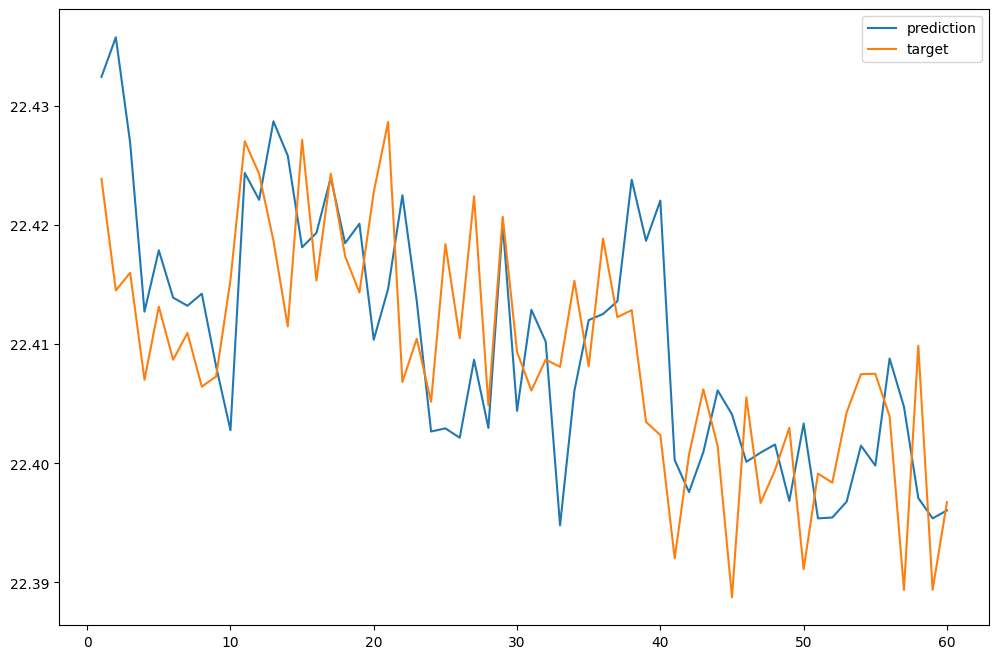

In [24]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[:60],label='prediction')
axes.plot(np.arange(1,61),target[:60],label='target')
axes.legend()

In [25]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.08248413354158401 %


In [26]:
pred_list

[22.432453155517578,
 22.435775756835938,
 22.42691993713379,
 22.412736892700195,
 22.417884826660156,
 22.41391372680664,
 22.413230895996094,
 22.414243698120117,
 22.408138275146484,
 22.402782440185547,
 22.424381256103516,
 22.42212677001953,
 22.42871856689453,
 22.425825119018555,
 22.418136596679688,
 22.41935920715332,
 22.423982620239258,
 22.418481826782227,
 22.42011833190918,
 22.410377502441406,
 22.414642333984375,
 22.422508239746094,
 22.413633346557617,
 22.402671813964844,
 22.402935028076172,
 22.40214729309082,
 22.408693313598633,
 22.402969360351562,
 22.42009162902832,
 22.404399871826172,
 22.41288948059082,
 22.41021728515625,
 22.394794464111328,
 22.406091690063477,
 22.41202735900879,
 22.412538528442383,
 22.413610458374023,
 22.42382049560547,
 22.418682098388672,
 22.42206573486328,
 22.4002742767334,
 22.3975887298584,
 22.40093994140625,
 22.406126022338867,
 22.404104232788086,
 22.400123596191406,
 22.400901794433594,
 22.401582717895508,
 22.396841

In [27]:
len(target)

10080

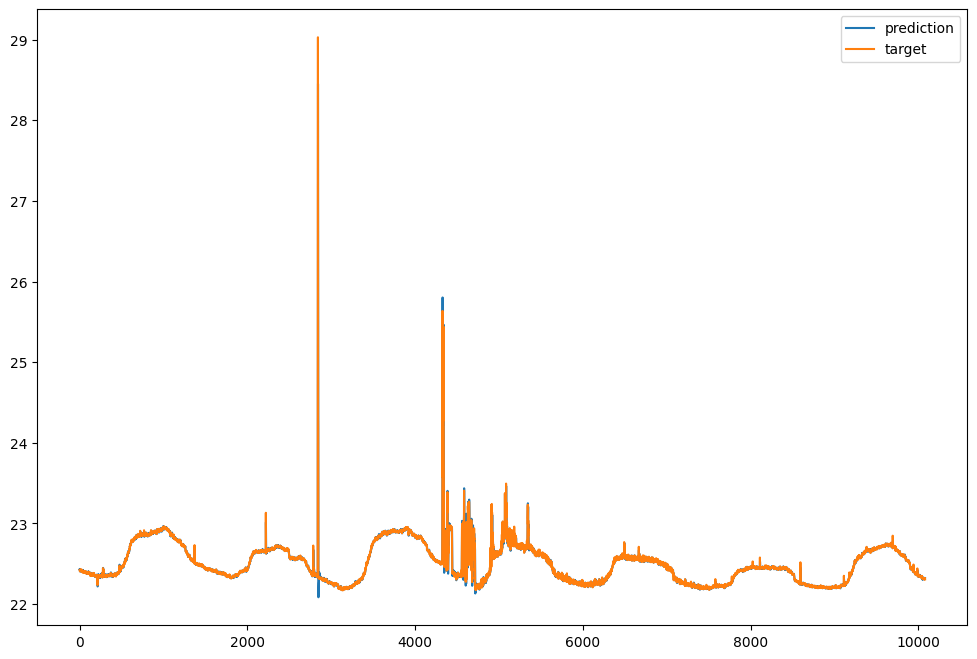

In [28]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

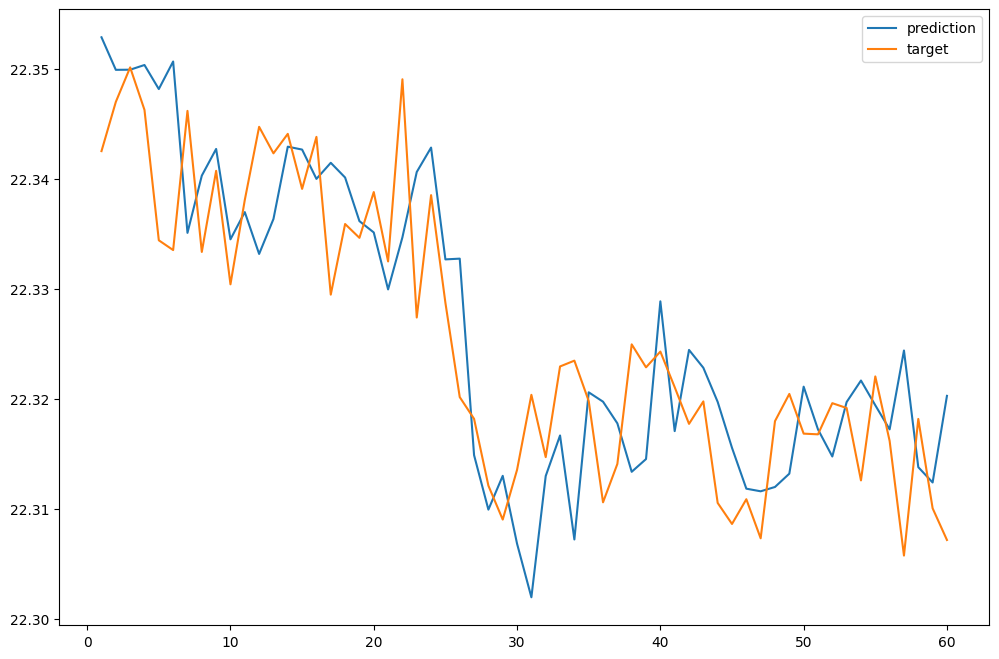

In [29]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

<font color = blue>이것으로 scaling을 하거나 LinearLayer를 추가하거나 둘중 하나만 하면 된다</font>

In [30]:
np.mean(time_list)

0.9689471089177661

1step과 비교했을때level을 맞추면서 sliding을 하게됨

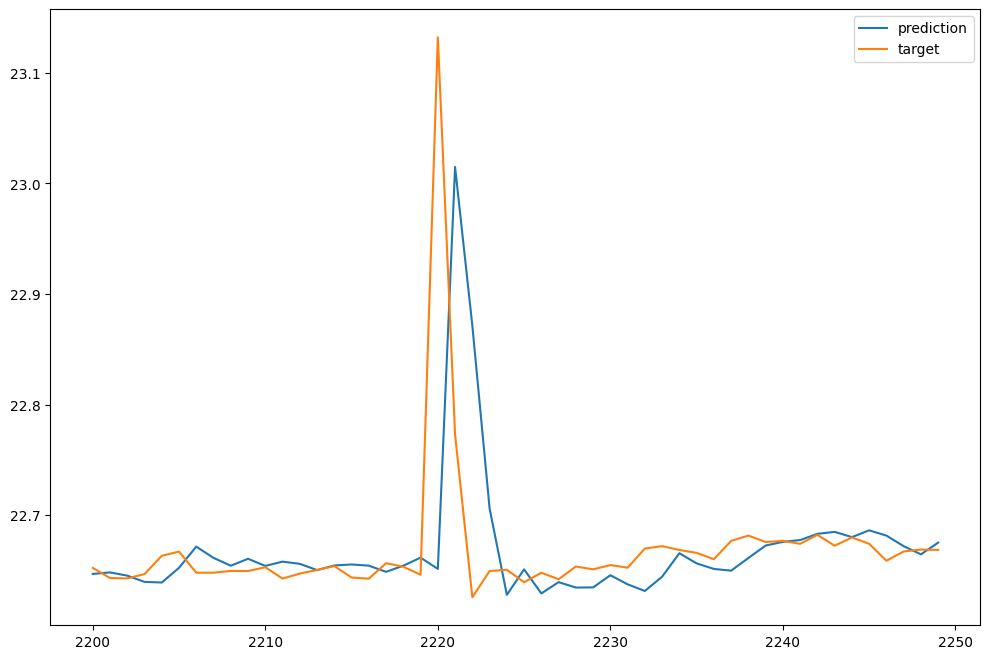

In [31]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()